In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import importlib
import sys
import copy
import os
from sklearn import preprocessing
from scripts.utils import time

MAIN_DIR = 'C:/Users/nourisa/Downloads/testProjs/proteomics_MSC/'
RESULTS_DIR = os.path.join(MAIN_DIR, 'results')
geneRNI_dir = os.path.join(MAIN_DIR,'..','geneRNI')
sys.path.insert(0, geneRNI_dir)

from geneRNI import geneRNI, tools, search_param
df_target = pd.read_csv('results/df_sig.csv')


# Run GRN using geneRNI framework
Steps:
- extract training data from the sig df
- add mg as a regulatory gene (0 for ctr and 1 for mg)
- combined the data of ctr and mg
- tune the param 
- extract regulatory links

In [9]:
# extract ctr and mg data
df_ctr = df_target.loc[:,['ctr_'+str(day) for day in time]].T
df_mg = df_target.loc[:,['mg_'+str(day) for day in time]].T
gene_names = list(df_target['Entry'].values)

# add mg as a regulatory factor with 0 for ctr and 1 for mg
# df_ctr['ctr_mg'] = np.zeros(len(time)) 
# df_mg['mg_mg'] = np.ones(len(time)) 
# gene_names.append('mg')

# normalize, equal variance
df_ctr_n = copy.deepcopy(df_ctr)
df_ctr_n.iloc[:,:] = preprocessing.scale(df_ctr.iloc[:,:])
df_mg_n = copy.deepcopy(df_mg)
df_mg_n.iloc[:,:] = preprocessing.scale(df_mg.iloc[:,:])

# get the data as arrays
data_ctr = df_ctr_n.values
data_mg = df_mg_n.values

# Xs, ys = tools.Data.process_time_series(TS_data=[data_ctr, data_mg], time_points=[time,time], gene_names=gene_names)
Xs, ys = tools.Data.process_time_series(TS_data=[data_ctr], time_points=[time], gene_names=gene_names)

print('shape including mg as input:', np.array(ys).shape, '(n_samples_time_series*n_genes)')

shape including mg as input: (48, 10) (n_samples_time_series*n_genes)


In [ ]:
# tune params using geneRNI: only train set
from geneRNI import search_param
importlib.reload(search_param)
specs = dict(
#     train_flag=True
)
param = dict(estimator_t = 'RF',random_state = 0)
param_grid = dict(alpha=np.arange(0,1,.05), min_samples_split=np.arange(2,5,1), min_samples_leaf=np.arange(1,5,1),max_depth=np.arange(10,20,1))
best_scores, best_params, best_ests, sampled_permts_sorted = search_param.rand_search(Xs, ys, param=param, param_grid=param_grid, n_jobs=10, n_sample=60, output_dir='results', **specs)
# plot best scores and best params
tools.GOF.boxplot_scores_single(best_scores)
tools.GOF.boxplot_params(best_params, priors=param_grid, samples=None)
print(f'mean best score {np.mean(best_scores)}')

In [ ]:
# GRN
import importlib
import json
importlib.reload(tools)
importlib.reload(geneRNI)
# read the outputs of param search
with open(os.path.join(MAIN_DIR,'results','best_params.txt'),'r') as f:
    best_params_outputs = eval(f.read())
best_params= best_params_outputs['best_params']
# run the network inference
param = dict(estimator_t='RF', random_state=0)
param = dict(estimator_t='RF', random_state=0)
Xs = Xs
ys = ys

ests, train_scores, links_df, oob_scores, test_scores = geneRNI.network_inference(Xs, ys, gene_names=gene_names, param=param, param_unique=best_params, Xs_test=None, ys_test=None, verbose=True, output_dir='results')

# # Run GRN using Portia

In [7]:
# portia
dir_portia = os.path.join(MAIN_DIR,'..','external/PORTIA-master')
sys.path.insert(0,dir_portia)
import portia as pt

In [15]:
dataset = pt.GeneExpressionDataset()
exp_id = 1
for data in df_ctr.values:
    dataset.add(pt.Experiment(exp_id, data))
    exp_id+=1
for data in df_mg.values:
    dataset.add(pt.Experiment(exp_id, data))
    exp_id+=1
print(f'n genes: {dataset.n_genes}, n samples: {dataset.n_samples}, n features: {dataset.n_features}')

n genes: 48, n samples: 11, n features: 48


In [16]:
M_bar = pt.run(dataset, method='fast')
links_df = tools.Links.format(M_bar, gene_names)

Gene expression matrix of shape (11, 48)


# Porcess the links
- Compare the extracted links to ground truth (those extracted by STRINGS) 
- Visualize the links

In [ ]:
# read the results
# links_df = pd.read_csv(os.path.join(MAIN_DIR,'results/links.txt'), index_col=0)
# examinations
# links_df.loc[links_df['Regulator']=='mg']
# links_df.loc[links_df['Target']=='mg']

In [20]:
# make a shortlist of the links 
cut_off = np.quantile(links_df['Weight'],q=.9)
# apply the cutoff: selected links
links_df_s = links_df.loc[links_df['Weight']>cut_off,:]
# read outputs of string
STR_LINKS_FILE = os.path.join(MAIN_DIR,'data','string_interactions_short.tsv')
MAP_GENES_FILE = os.path.join(MAIN_DIR,'data','string_mapping.tsv')
# extract links from string
df_links_str = pd.read_csv(STR_LINKS_FILE, sep='\t')
df_links_str = df_links_str.rename(columns={'#node1':'Regulator','node2':'Target','combined_score':'Weight'})
df_links_str = df_links_str.loc[:,['Regulator','Target','Weight']]  
# read mapping: strings uses different names 
df_gene_maps = pd.read_csv(MAP_GENES_FILE, sep='\t')
gene_maps = {}
for queryItem, preferredName in zip(df_gene_maps['queryItem'].values,df_gene_maps['preferredName'].values):
    gene_maps.update({preferredName:queryItem})
print(f'Number of string links: {len(df_links_str)}')
print(f'Number of extracted links: {len(links_df_s)}')
if len(df_links_str)>len(links_df_s):
    raise ValueError('Extracted links cannot be lesser than golden links')
# scale to have equal variance of 1
# df_links_str.loc[:,'Weight'] = preprocessing.scale(df_links_str.loc[:,'Weight'].values)
# df_s.loc[:,'Weight'] = preprocessing.scale(df_s.loc[:,'Weight'].values)
print(f"Golden, mean: {np.mean(df_links_str.loc[:,'Weight'])} std: {np.std(df_links_str['Weight'])}")
print(f"Extracted, mean: {np.mean(links_df_s['Weight'])} std: {np.std(links_df_s['Weight'])}")

# how many of string links are included in the extracted links
regs = df_links_str['Regulator'].values
targs = df_links_str['Target'].values
pairs = [(reg,targ) for reg,targ in zip(regs, targs)]
found = []
for pair in pairs:
    step1_df = links_df_s.loc[links_df_s['Regulator']==gene_maps[pair[0]],:]
    found.append(np.any(step1_df['Target'] == gene_maps[pair[1]]))
print(f'Number of matched links: {np.count_nonzero(np.array(found))}')

Number of string links: 58
Number of extracted links: 226
Golden, mean: 0.6209482758620688 std: 0.19735932767712114
Extracted, mean: 0.4958262729778746 std: 0.1238190228975213
Number of matched links: 8


### Visualize

In [21]:
# calculate sum of outgoing links
import copy
sum_ws = [sum(links_df.loc[links_df['Regulator']==gene,:]['Weight']) for gene in gene_names]
df_sum_ws = pd.DataFrame(data={'Entry':gene_names,'SumWeight':sum_ws})
df_sum_ws_s = df_sum_ws.sort_values('SumWeight')
vertex_sizes = sum_ws
# replace the names with indices: index of the genes in the gene_names
df_s = copy.deepcopy(links_df_s)
df_s.loc[:,'Regulator'] = [gene_names.index(name) for name in list(df_s['Regulator'].values)]
df_s.loc[:,'Target'] = [gene_names.index(name) for name in list(df_s['Target'].values)]
edges = df_s.loc[:,['Regulator','Target']].values
weights = df_s['Weight'].values
print(f'number of links to visualize {len(df_s)}')

number of links to visualize 226


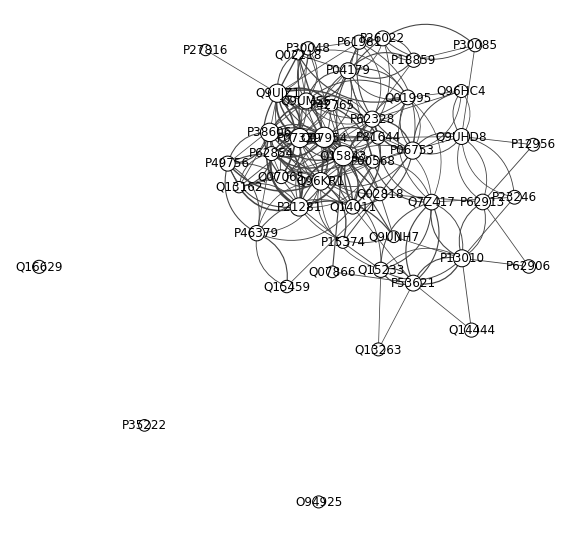

In [22]:
# visualize the links
import igraph as ig
import matplotlib.pyplot as plt

# Construct a graph with 3 vertices
n_vertices = len(gene_names)
g = ig.Graph(n_vertices, edges, directed=False)

# Set attributes for the graph, nodes, and edges
g["title"] = "Regulatory network"
g.vs["name"] = gene_names
g.vs["weights"] = weights
g.vs["vertex_sizes"] = vertex_sizes
# Plot in matplotlib
fig, ax = plt.subplots(figsize=(10,10))
vertex_size_correction = .4/np.max(vertex_sizes)
edge_size_correction = 2/np.max(weights)
ig.plot(
    g,
    target=ax,
    layout="kk", # print nodes in a circular layout
    vertex_size=[x*vertex_size_correction for x in g.vs["vertex_sizes"]],
    vertex_color="white",
#     vertex_frame_width=8,
#     vertex_frame_color="white",
    vertex_label=g.vs["name"],
    vertex_label_size=12,
    edge_width=[x*edge_size_correction for x in weights],
    edge_arrow_width = .5
#     edge_color=["#7142cf" if x>np.mean(g.es['weights']) else "#AAA" for married in g.es["married"]]
)

plt.show()

# Save the graph as an image file
fig.savefig('RGN.png') 